In [ ]:
#make sure your drive path is correct! 
# macOS/OS X
# drive_path = '/Volumes/Brain2017/data/dynamic-brain-workshop/brain_observatory_cache/'

# Windows (a good guess)
# drive_path = 'e:/data/dynamic-brain-workshop/brain_observatory_cache'

# Linux (will vary; the following is possibly what Ubuntu will do)
# drive_path = '/media/Brain2017/data/dynamic-brain-workshop/brain_observatory_cache'

# AWS
drive_path = '/data/dynamic-brain-workshop/brain_observatory_cache/'

In [ ]:
# We need to import these modules to get started
import numpy as np
import pandas as pd
import os
import sys
import h5py
import seaborn as sns 

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = os.path.join(drive_path,'brain_observatory_manifest.json')
print manifest_file

boc = BrainObservatoryCache(manifest_file=manifest_file)

In [ ]:
def vectorize(mat):
    """Takes a square symmetric matrix mat and returns the vectorized form. Like matlab's squareform.

         Note: could probably also just use scipy's squareform function."""
    assert mat.shape[0] == mat.shape[1]

    vec = mat[:, 0]
    for row in range(1, mat.shape[1]):
        vec = np.concatenate((vec, mat[row:, row]))

    return vec

In [ ]:
from scipy.stats import kendalltau as kt
import numpy as np
import scipy.spatial.distance
def get_kt(rsm1,rsm2):
    '''Gets Kendall tau-a measurements between two RDM matrices, first vectorizes matrices
    and then computes kt using scipy kendall-tau function'''
    np.fill_diagonal(rsm1,0)
    np.fill_diagonal(rsm2,0)
    vec_rsm1 = vectorize(rsm1)
    #
    vec_rsm2 = vectorize(rsm2)

    #vec_rsm1 = scipy.spatial.distance.squareform(rsm1)
    #vec_rsm2 = scipy.spatial.distance.squareform(rsm2)
    k = kt(vec_rsm1, vec_rsm2).correlation
    return k

In [186]:
exps=pd.read_hdf(r'/home/arib/SWDB_2017/swdb_2017_tools/projects/mouseRSA/exps_w_RSA.h5',mode='r')

In [187]:
exps.head()

,cre_line,donor_name,failed,id,imaging_depth,reporter_line,specimen_name,tags,targeted_structure,rsa_mean_mean_mahala,rsa_random_mean_mahala,rsa_mean_mean_spectral_embedding,rsa_mean_mean_PCA
0,Cux2-CreERT2,283284,False,566759225,275,Ai93(TITL-GCaMP6f),Cux2-CreERT2;Camk2a-tTA;Ai93-283284,[],VISam,"[[0.0, 15.0717277058, 11.2159497239, 12.801501...","[[0.0, 408.7510518, 728.859229155, 195.1421962...","[[0.0, 23.0786825252, 21.2174191481, 22.739709...","[[0.0, 23.0786825252, 21.2174191481, 22.739709..."
1,Nr5a1-Cre,261969,False,546328009,350,Ai93(TITL-GCaMP6f),Nr5a1-Cre;Camk2a-tTA;Ai93-261969,[],VISal,"[[0.0, 0.741935932081, 0.599953696213, 0.80095...","[[0.0, 143.908233009, 164.715318686, 153.82373...","[[0.0, 7.53542946705, 3.31196403877, 9.4400437...","[[0.0, 7.53542946705, 3.31196403877, 9.4400437..."
2,Scnn1a-Tg3-Cre,230570,False,511510911,350,Ai93(TITL-GCaMP6f),Scnn1a-Tg3-Cre;Camk2a-tTA;Ai93-230570,[],VISp,"[[0.0, 9.96030325168, 10.2589451811, 8.3752674...","[[0.0, 141.371157393, 138.359844623, 122.63777...","[[0.0, 24.1404450884, 30.7306092291, 21.571387...","[[0.0, 24.1404450884, 30.7306092291, 21.571387..."
3,Emx1-IRES-Cre,284669,False,569792815,375,Ai93(TITL-GCaMP6f),Emx1-IRES-Cre;Camk2a-tTA;Ai93-284669,[],VISam,"[[0.0, 3.49558131281, 2.87681318643, 2.5342243...","[[0.0, 72.8745307828, 57.7551496791, 83.791995...","[[0.0, 8.53032612269, 9.03611995897, 6.9925695...","[[0.0, 8.53032612269, 9.03611995897, 6.9925695..."
4,Rbp4-Cre_KL100,234584,False,511511015,375,Ai93(TITL-GCaMP6f),Rbp4-Cre;Camk2a-tTA;Ai93-234584,[],VISpm,"[[0.0, 3.58087458183, 2.79741660163, 3.4468557...","[[0.0, 84.7254841698, 72.4271748847, 136.35898...","[[0.0, 26.8089158925, 21.1489539612, 25.902355...","[[0.0, 26.8089158925, 21.1489539612, 25.902355..."


In [188]:
exps.loc[(exps.imaging_depth>100) & (exps.imaging_depth<=200),'imaging_depth']=175

exps.loc[(exps.imaging_depth>300) & (exps.imaging_depth<500),'imaging_depth']=350
exps.loc[(exps.imaging_depth>200) & (exps.imaging_depth<=300),'imaging_depth']=275
exps.loc[(exps.cre_line=='Nr5a1-Cre'),'imaging_depth']=275

In [275]:
def get_population_rf(boc, experiment_id):
    c_flag = 'C'
    lsn_name = 'locally_sparse_noise'
    rf_name = 'receptive_field_lsn'
    #
    for a in boc.get_ophys_experiments(experiment_container_ids=[experiment_id]):
        if a['session_type'].endswith('2'):
            c_flag = 'C2'
            if a['targeted_structure'] != 'VISp':
                lsn_name = 'locally_sparse_noise_8deg'
                rf_name = 'receptive_field_lsn8'
            else:
                lsn_name = 'locally_sparse_noise_4deg'
                rf_name = 'receptive_field_lsn4'

    drive_path = boc.manifest.get_path('BASEDIR')
    if c_flag=='C':
        session_id = boc.get_ophys_experiments(experiment_container_ids=[experiment_id], stimuli=[lsn_name])[0]['id']
        analysis_file = os.path.join(drive_path, 'ophys_experiment_analysis', str(session_id)+'_three_session_C_analysis.h5')
    elif c_flag=='C2':    
        session_id = boc.get_ophys_experiments(experiment_container_ids=[experiment_id], stimuli=[lsn_name])[0]['id']
        analysis_file = os.path.join(drive_path, 'ophys_experiment_analysis', str(session_id)+'_three_session_C2_analysis.h5')

    
    f = h5py.File(analysis_file, 'r')
    receptive_field = f['analysis'][rf_name].value
    f.close()
    pop_rf = np.nansum(receptive_field, axis=(2,3))
    return pop_rf

In [ ]:
def get_experiments_grouped(exps,targeted_structures,cre_lines,imaging_depths,donor_name=None,rsm_selection='mean'):
    ''' Gets Kendall tau measurement for all matrices for a certain list of
    visual areas, cre lines, and imaging depths
    If multiple RSAs exist for one mouse, average them together
    If multiple RSAs for one targeted structure, cre line, or imaging depth 
    
    For now, takes a list of ei'''
    #if type(imaging_depths)!='list':
    #    imaging_depths=[imaging_depths]
    #if type(cre_lines)!='list':
    #    cre_lines=[cre_lines]
    
    exps_grouped=pd.DataFrame(columns=['cre_line','imaging_depth','targeted_structure','rsm'])
    for cre_line in cre_lines:
        imaging_depths=exps[exps.cre_line==cre_line].imaging_depth.unique()
        for imaging_depth in imaging_depths:
            for targeted_structure in targeted_structures:
                available_targeted_structures=exps[(exps.cre_line==cre_line) & (exps.imaging_depth==imaging_depth)].targeted_structure.unique()
                if targeted_structure in available_targeted_structures:
                    
                    if receptive is simialary:
                    if rsm_selection=='mean':
                        rsm=exps.groupby(['cre_line','imaging_depth','targeted_structure']).get_group((cre_line,imaging_depth,targeted_structure)).rsa_mean_mean_mahala.mean()
                    elif rsm_selection=='random':
                        rsm=exps.groupby(['cre_line','imaging_depth','targeted_structure']).get_group((cre_line,imaging_depth,targeted_structure)).rsa_mean_mean_mahala.iloc[np.random.randint(0,high=exps.groupby(['cre_line','imaging_depth','targeted_structure']).get_group((cre_line,imaging_depth,targeted_structure)).shape[0])]
                    to_add=pd.DataFrame(data=[cre_line,imaging_depth,targeted_structure,rsm],index=['cre_line','imaging_depth','targeted_structure','rsm'])                
                    exps_grouped=exps_grouped.append(to_add.T,ignore_index=True)
                else:
                    continue
    return exps_grouped

def get_kt_matrix(exps_grouped,compare):
    if compare=='targeted_structure':
        cre_lines=exps_grouped.cre_line.unique()
        for cre_line in cre_lines:
            imaging_depths=exps_grouped[exps_grouped.cre_line==cre_line].imaging_depth.unique()
            for imaging_depth in imaging_depths:
                exps_to_compare=exps_grouped.groupby(['cre_line','imaging_depth']).get_group((cre_line,imaging_depth))
                to_compare=exps_to_compare[compare]
                kt_matrix=np.zeros((len(to_compare),len(to_compare)))

                for i,rsm1 in enumerate(exps_to_compare.rsm):
                    for j,rsm2 in enumerate(exps_to_compare.rsm): 

                        kt_matrix[i,j]=get_kt(rsm1,rsm2)
                np.fill_diagonal(kt_matrix,0)
                kt_df=pd.DataFrame(data=kt_matrix,columns=to_compare,index=to_compare)
                fig=plt.figure()
                fig.add_subplot(111)
                if cre_line=='Cux2-CreERT2':
                    to_return=kt_df
                sns.heatmap(kt_df,vmin=0)
                plt.title(cre_line+' '+str(imaging_depth))
                
    elif compare=='imaging_depth':
        cre_lines=exps_grouped.cre_line.unique()
        for cre_line in cre_lines:
            targeted_structures=exps_grouped[exps_grouped.cre_line==cre_line].targeted_structure.unique()
            for targeted_structure in targeted_structures:
                exps_to_compare=exps_grouped.groupby(['cre_line','targeted_structure']).get_group((cre_line,targeted_structure))
                to_compare=exps_to_compare[compare]
                kt_matrix=np.zeros((len(to_compare),len(to_compare)))

                for i,rsm1 in enumerate(exps_to_compare.rsm):
                    for j,rsm2 in enumerate(exps_to_compare.rsm): 
                        kt_matrix[i,j]=get_kt(rsm1,rsm2)
                np.fill_diagonal(kt_matrix,0)
                kt_df=pd.DataFrame(data=kt_matrix,columns=to_compare,index=to_compare)
                fig=plt.figure()
                fig.add_subplot(111)
                sns.heatmap(kt_df,vmin=0)
                plt.title(cre_line+' '+str(targeted_structure))
                
    return to_return
        

    

In [ ]:
def get_receptive_field_COMS(exps):
    for exp in exps.id.values:

In [270]:
exp_id = exps.id.values[0]
session = boc.get_ophys_experiments(experiment_container_ids=[exp_id], stimuli=['natural_scenes'])

session_id =[session[i]['id'] for i in range(len(session)) 
                 if session[i]['session_type']=='three_session_B'][0]

data_set = boc.get_ophys_experiment_data(ophys_experiment_id=session_id)


In [277]:
rf = get_population_rf(boc, exp_id)

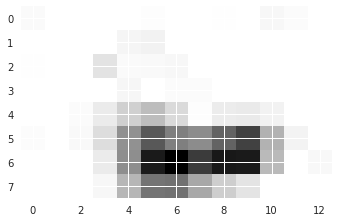

In [280]:
plt.imshow(rf)

In [ ]:
ns.get

In [191]:
def get_experiments_grouped(exps,targeted_structures,cre_lines,imaging_depths,
                            rsm_name = 'rsa_mean_mean_mahala', 
                            donor_name=None,rsm_selection='mean'):
    ''' Gets Kendall tau measurement for all matrices for a certain list of
    visual areas, cre lines, and imaging depths
    If multiple RSAs exist for one mouse, average them together
    If multiple RSAs for one targeted structure, cre line, or imaging depth 
    
    For now, takes a list of ei'''
    #if type(imaging_depths)!='list':
    #    imaging_depths=[imaging_depths]
    #if type(cre_lines)!='list':
    #    cre_lines=[cre_lines]
    
    exps_grouped=pd.DataFrame(columns=['cre_line','imaging_depth','targeted_structure','rsm'])
    for cre_line in cre_lines:
        imaging_depths=exps[exps.cre_line==cre_line].imaging_depth.unique()
        for imaging_depth in imaging_depths:
            for targeted_structure in targeted_structures:
                available_targeted_structures=exps[(exps.cre_line==cre_line) & 
                                                   (exps.imaging_depth==imaging_depth)].targeted_structure.unique()
                if targeted_structure in available_targeted_structures:
                    if rsm_selection=='mean':
                        rsm=exps.groupby(['cre_line','imaging_depth','targeted_structure']).get_group(
                            (cre_line,imaging_depth,targeted_structure))[rsm_name].mean()
                        to_add=pd.DataFrame(data=[cre_line,imaging_depth,targeted_structure,rsm],
                                            index=['cre_line','imaging_depth','targeted_structure','rsm'])
                    elif rsm_selection=='random':
                        rsm=exps.groupby(['cre_line','imaging_depth','targeted_structure']).get_group(
                            (cre_line,imaging_depth,targeted_structure))[rsm_name].iloc[np.random.randint(
                            0,high=exps.groupby(['cre_line','imaging_depth','targeted_structure']).get_group(
                                (cre_line,imaging_depth,targeted_structure)).shape[0])]
                        
                        to_add=pd.DataFrame(data=[cre_line,imaging_depth,targeted_structure,rsm],
                                            index=['cre_line','imaging_depth','targeted_structure','rsm'])
                    elif rsm_selection=='all':
                        rsm=exps.groupby(['cre_line','imaging_depth','targeted_structure']).get_group(
                            (cre_line,imaging_depth,targeted_structure))[rsm_name]
                        to_add=pd.DataFrame(data=[cre_line,imaging_depth,targeted_structure,rsm.iloc[0]],
                                            index=['cre_line','imaging_depth','targeted_structure','rsm'])    
                        
                        for n in range(1,rsm.shape[0]):
                            to_add[str(n)]=pd.Series([cre_line,imaging_depth,
                                                      targeted_structure,rsm.iloc[n]],
                                                     index=['cre_line','imaging_depth','targeted_structure','rsm'])
                    exps_grouped=exps_grouped.append(to_add.T,ignore_index=True)
                    
                else:
                    continue
    return exps_grouped

def get_kt_matrix(exps_grouped,compare):
    kt_dfs = []
    if compare=='targeted_structure':
        cre_lines=exps_grouped.cre_line.unique()
        for cre_line in cre_lines:
            imaging_depths=exps_grouped[exps_grouped.cre_line==cre_line].imaging_depth.unique()
            for imaging_depth in imaging_depths:
                exps_to_compare=exps_grouped.groupby(['cre_line','imaging_depth']).get_group((cre_line,imaging_depth))
                to_compare=exps_to_compare[compare]
                kt_matrix=np.zeros((len(to_compare),len(to_compare)))

                for i,rsm1 in enumerate(exps_to_compare.rsm):
                    for j,rsm2 in enumerate(exps_to_compare.rsm): 

                        kt_matrix[i,j]=get_kt(rsm1,rsm2)
                np.fill_diagonal(kt_matrix,0)
                kt_df=pd.DataFrame(data=kt_matrix,columns=to_compare,index=to_compare)
                fig=plt.figure()
                fig.add_subplot(111)
                kt_dfs.append(kt_df)
                sns.heatmap(kt_df,vmin=0)
                plt.title(cre_line+' '+str(imaging_depth))
                
    elif compare=='imaging_depth':
        cre_lines=exps_grouped.cre_line.unique()
        for cre_line in cre_lines:
            targeted_structures=exps_grouped[exps_grouped.cre_line==cre_line].targeted_structure.unique()
            for targeted_structure in targeted_structures:
                exps_to_compare=exps_grouped.groupby(['cre_line','targeted_structure']).get_group((cre_line,targeted_structure))
                to_compare=exps_to_compare[compare]
                kt_matrix=np.zeros((len(to_compare),len(to_compare)))

                for i,rsm1 in enumerate(exps_to_compare.rsm):
                    for j,rsm2 in enumerate(exps_to_compare.rsm): 
                        kt_matrix[i,j]=get_kt(rsm1,rsm2)
                np.fill_diagonal(kt_matrix,0)
                kt_df=pd.DataFrame(data=kt_matrix,columns=to_compare,index=to_compare)
                fig=plt.figure()
                fig.add_subplot(111)
                sns.heatmap(kt_df,vmin=0,vmax=0.5)
                plt.title(cre_line+' '+str(targeted_structure))
                
    return kt_dfs
        

    

In [254]:
def get_all_kt_matrix(exps_grouped, distance_metric = 'kt'):
    kt = np.zeros((len(exps_grouped),len(exps_grouped)))
    
    
    if distance_metric == 'kt':
        for i,rsm1 in enumerate(exps_grouped.rsm):
            for j,rsm2 in enumerate(exps_grouped.rsm): 
                if i<j:
                    kt[i,j]=get_kt(rsm1,rsm2)
            
        kt = np.triu(kt) + np.triu(kt, 1).T 
    else:
        resps = get_unfolded_rsm(exps_grouped)
        kt = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(resps, distance_metric))
        
        
    kt_df=pd.DataFrame(data=kt,columns=exps_grouped.targeted_structure,index=exps_grouped.targeted_structure)
    
   
                
    return kt_df

In [ ]:
# within area RSM comparisons 

In [ ]:
cre_lines=[u'Cux2-CreERT2',
 u'Emx1-IRES-Cre',
 u'Nr5a1-Cre',
 u'Rbp4-Cre_KL100',
 u'Rorb-IRES2-Cre']
imaging_depths=boc.get_all_cre_lines()
targeted_structures=boc.get_all_targeted_structures()
cre_lines

In [229]:
exps_grouped=get_experiments_grouped(exps.iloc[:,:143],targeted_structures,cre_lines,imaging_depths,
                                     rsm_name = 'rsa_mean_mean_mahala',
                                     rsm_selection='all')


In [221]:
def iszero(arg):
    if isinstance(arg,int):
        return False
    else: return True

In [223]:
just_nonzeros = exps_grouped[exps_grouped.rsm.apply(iszero)]

In [244]:
kt_all = get_all_kt_matrix(exps_grouped)

In [251]:
kt_all = kt_all.sort_index(axis=0).sort_index(axis=1)

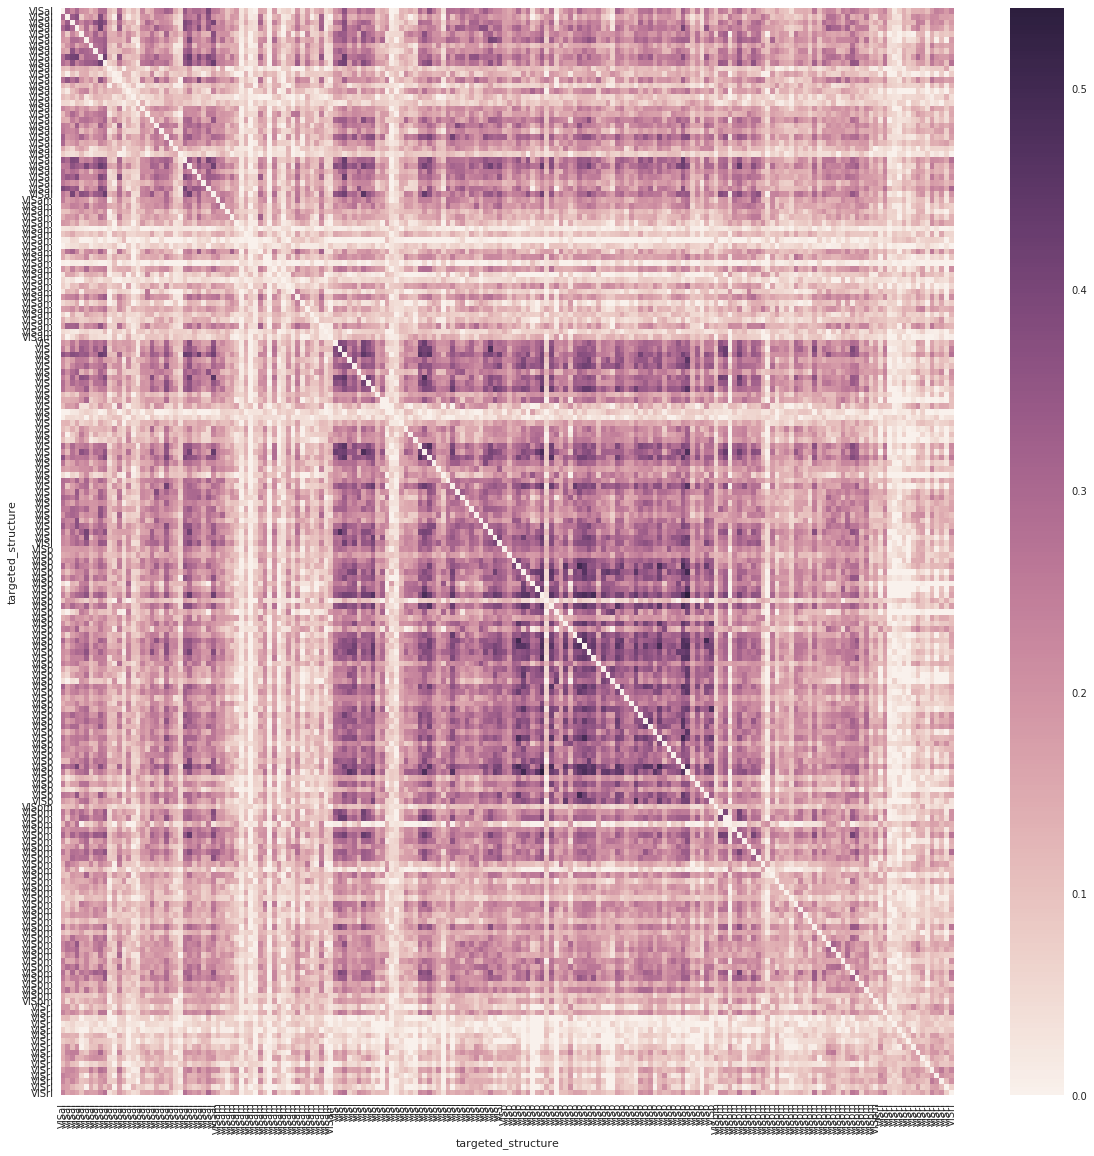

In [252]:
plt.figure(figsize=(20,20))
sns.heatmap(kt_all,vmin=0)


In [264]:
kt_all_euclidean = get_all_kt_matrix(exps_grouped, 'seuclidean').sort_index(axis=0).sort_index(axis=1)

(array([  5590.,  13544.,   9634.,   4722.,   1840.,    706.,     64.,
             0.,      0.,      0.]),
 array([    0.,   100.,   200.,   300.,   400.,   500.,   600.,   700.,
          800.,   900.,  1000.]),
 <a list of 10 Patch objects>)

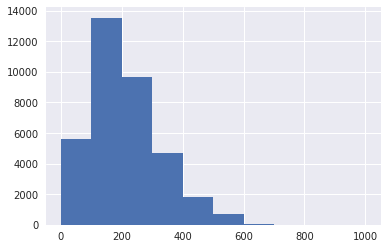

In [266]:
plt.hist(kt_all_euclidean.values.flatten(),range=(0,1e3))

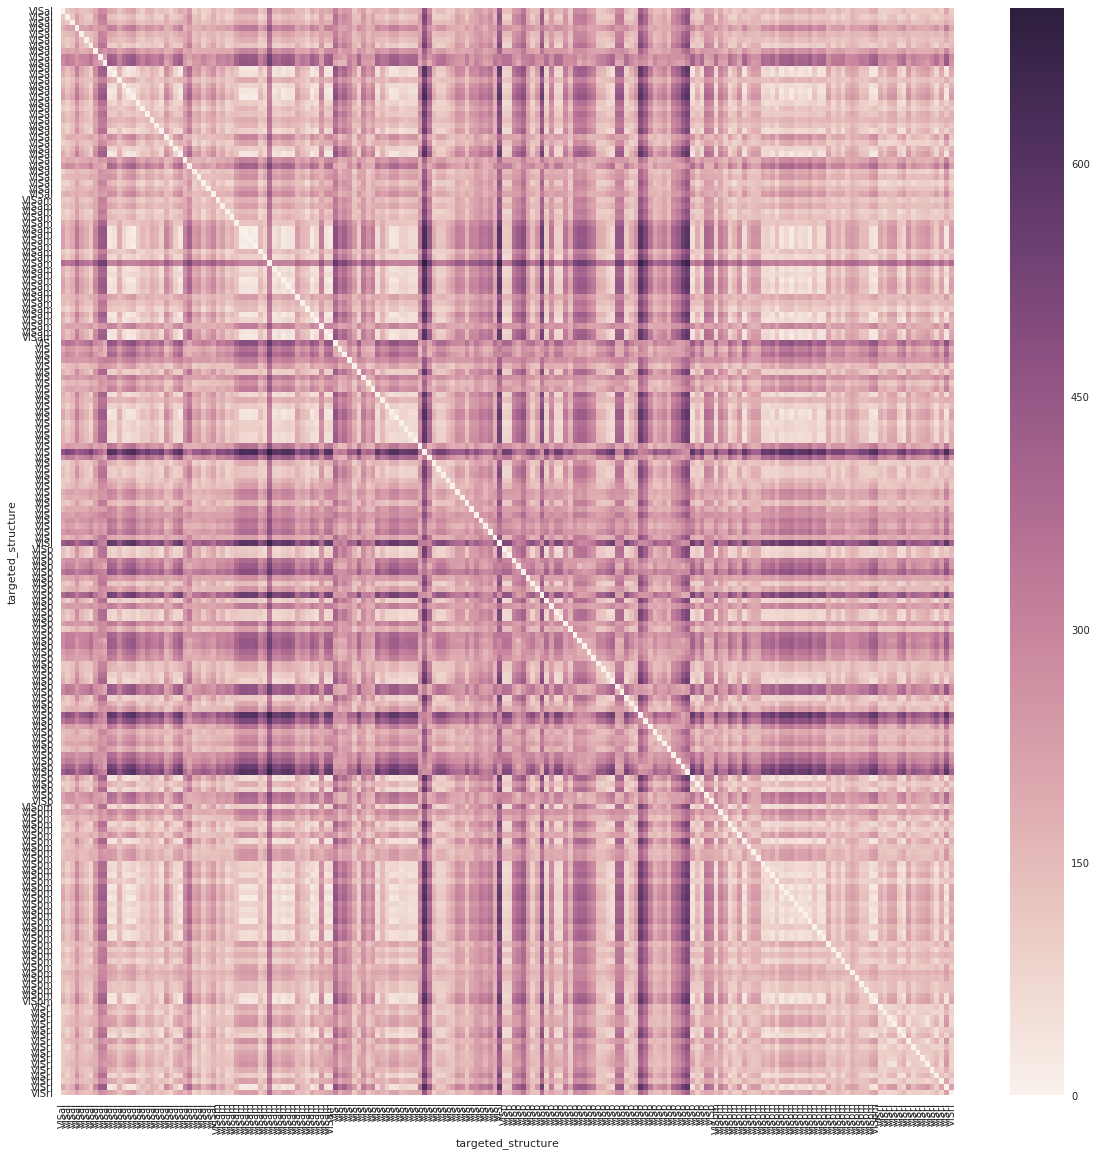

In [267]:
plt.figure(figsize=(20,20))
sns.heatmap(kt_all_euclidean,vmin=0, vmax = 7e2)

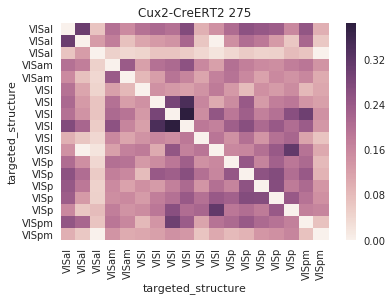

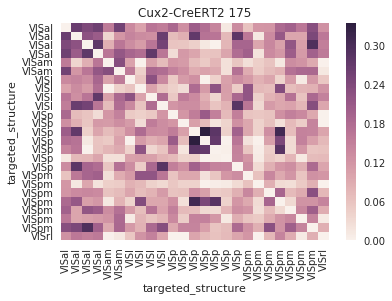

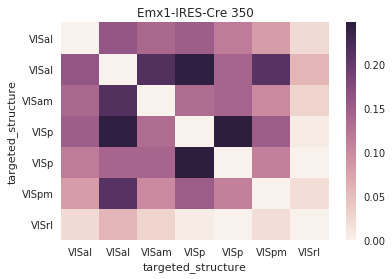

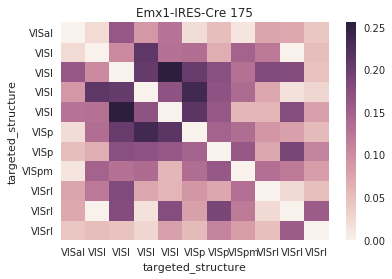

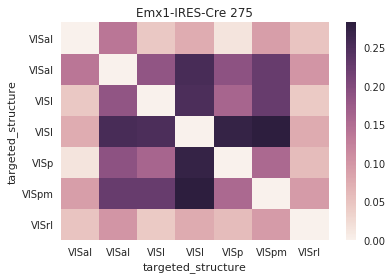

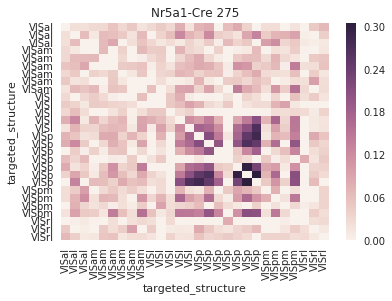

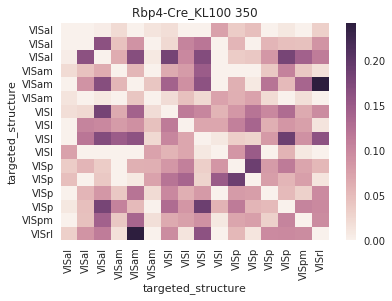

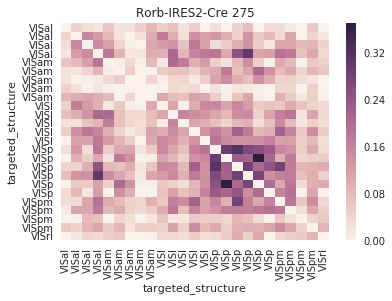

In [224]:
kt_dfs=get_kt_matrix(just_nonzeros,'targeted_structure')

In [ ]:
# to do: modify get_experiments_grouped so that it takes into account the valid_stimuli columns

In [ ]:
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, TSNE, MDS
from sklearn.decomposition import PCA

In [ ]:
def get_unfolded_rsm(exps_grouped):
    """Takes the result of get_experiments_grouped and performs a 2D embedding on the rsms.
    Output: 2D numpy array of length number_experiments"""
    n_stim = exps_grouped.loc[0,'rsm'].shape[0]
    matrix_to_embed = np.vstack(
                        exps_grouped.rsm.apply( # apply this function to each rsm
                                scipy.spatial.distance.squareform))
        
    return matrix_to_embed

In [ ]:
def scatter_viz(to_plot,exps_grouped):
    
    plt.subplots_adjust(bottom = 0.1)
    plt.subplots_adjust(bottom = 0.1)

    areas = exps_grouped.targeted_structure
    
    for area in areas.unique():

        plt.scatter(
            to_plot[areas.values==area, 0], to_plot[areas.values==area, 1], marker = 'o'
            )

    plt.legend(areas.unique())

In [ ]:
to_embed = get_unfolded_rsm(exps_grouped)

Reduce dimensions with PCA then run tsne

In [ ]:
se = SpectralEmbedding(n_components = 10)
se_rsm = se.fit_transform(to_embed)

In [ ]:
tsne = TSNE(perplexity=5.0,metric=)
to_plot = tsne.fit_transform(to_embed)
scatter_viz(to_plot, exps_grouped)

In [ ]:
method = LocallyLinearEmbedding(n_components=2)
to_plot = method.fit_transform(to_embed)
scatter_viz(to_plot, exps_grouped)

In [ ]:
method = SpectralEmbedding(n_components=3)
to_plot = method.fit_transform(to_embed)

pca = PCA(n_components=2, whiten=False)
to_plot = pca.fit_transform(to_plot)
scatter_viz(to_plot, exps_grouped)

In [ ]:
method = PCA(n_components=2)
to_plot = method.fit_transform(to_embed)
scatter_viz(to_plot, exps_grouped)

In [ ]:
method = MDS(n_components=2,eps = 1e-1)
to_plot = method.fit_transform(to_embed)
scatter_viz(to_plot, exps_grouped)

Or let's try to visualize the kts with MDS

In [184]:
kt_df = kt_dfs[-1]
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(1-kt_df.values)
to_plot = results.embedding_

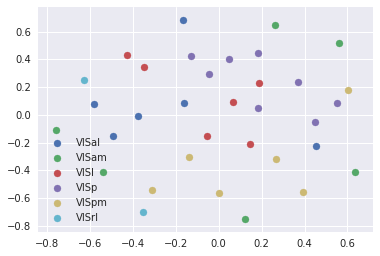

In [185]:

plt.subplots_adjust(bottom = 0.1)
plt.subplots_adjust(bottom = 0.1)

areas = kt_df.columns

for area in areas.unique():

    plt.scatter(
        to_plot[areas==area, 0], to_plot[areas==area, 1], marker = 'o'
        )

plt.legend(areas.unique())

In [ ]:
exps_grouped.loc['targeted_stuctured']

In [ ]:
exps_grouped.head()

In [ ]:
exps_grouped['targeted_structure'].unique()

In [ ]:
available_targeted_structures=exps[(exps.cre_line==cre_line) & (exps.imaging_depth==imaging_depth)].targeted_structure.unique()
available_targeted_structures

In [ ]:
for cre_line in cre_lines
sns.heatmap(kt_df)
plt.title(cre_lines+imaging_depths)

In [ ]:
np.fill_diagonal(kt_matrix,0)
sns.heatmap(kt_matrix)

In [ ]:
rsm=exps.groupby(['cre_line','imaging_depth','targeted_structure']).get_group((cre_line,imaging_depth,targeted_structure)).rsm.mean()

In [ ]:
to_add=pd.DataFrame(data=[cre_line,imaging_depth,targeted_structure,rsm],index=['cre_line','imaging_depth','targeted_structure','rsm'])

In [ ]:
exps_grouped=exps_grouped.append(to_add.T)

In [ ]:
exps_grouped.head()